In [2]:
import numpy as np
from astropy.io.ascii import read 
from scipy.interpolate import interp1d
from scipy.integrate import trapz
import seaborn as sea
import matplotlib.pyplot as plt
from astropy.io import fits
import PyPDF2
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
%matplotlib inline

In [3]:
# read in temp, log g, and suggested Kurucz model for each spectral type 
readme = open('README_STELLAR_MODELS')
spec_info = readme.readlines()[139:180]

spec_type, temp, log_g, kmodel = [], [], [], []

for line in spec_info:
    param = line.split()
    # place each item in the appropriate column 
    for i in range(len(param)):
        if i == 0:
            spec_type.append(param[i])
        elif i == 1:
            temp.append(int(param[i]))
        elif i == 2:
            log_g.append(float(param[i]))
        else:
            kmodel.append(param[i])

In [4]:
# information from reference file 
masses = [120, 60,25, 12, 5, 2.5, 1.25, 1, 0.8, 0.5, 0.2, 0.1, \
          120, 60, 25, 12, 5, 2.5, 1.25,1, 0.8 ] # in solar masses 
s_type = ['O3V', 'O4V', 'O8V', 'B0.2V', 'B5V', 'B9V', 'F5V', 'G8V', \
          'K2V', 'M0V', 'M4V', 'M7V', 'O9I', 'B7I', 'B0I', 'B0.5I', 'B5I', 'A2III', 'G0V', 'G2V', 'K0V']
logL = [6.25, 5.73, 5.29, 4.01, 2.74, 1.60, 0.32, -0.16, -0.61, -1.42, -2.2, -3.0, \
        6.34, 5.99, 5.29, 4.46, 3.15, 1.92, 0.66, 0.22, -0.09]
teff = [53300, 48200, 37900, 28000, 17200, 10700, 6830,5640,4860,3890,3300,2900, \
        32900, 12000,29000,24400,15100, 9000, 6070, 5790, 5360]
tau  = [2.56E-3, 3.45E-3, 6.51E-3, 1.6E-2, 9.45E-2, 0.585, 4.91, 9.84, 25, 1E2, 4E3, 1E4] # in Gyr
radius = [16, 10, 6.5, 4.3, 2.7, 1.8, 1.2, 0.9, 0.7, 0.4, 0.2, 0.1, 48, \
          230, 18, 9.5, 5.5, 3.8, 1.9, 1.3, 1.1] # in solar radii

In [5]:
# exclude post main-sequence objects 
ms_ref = [s_type.index(i) for i in s_type if 'V' in i]
ms_model = [spec_type.index(i) for i in spec_type if 'V' in i]

In [6]:
# create object to interpolate across luminosity and temperature 
interpL_obj = interp1d(np.array(teff)[ms_ref], np.array(logL)[ms_ref], kind='cubic')
interpL = interpL_obj(np.array(temp)[ms_model])

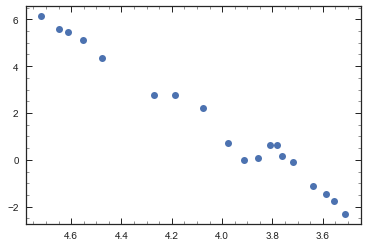

In [7]:
plt.gca().invert_xaxis()
plt.plot(np.log10(np.array(temp)[ms_model]), interpL, 'o')

In [8]:
# now that we have a luminosity for every kucucz spectral type, find their masses
# using the appropriate mass-luminosity relation

mass = []
for luminosity in interpL:
    if luminosity < -1.48 : 
        factor = 0.23; exp = 2.3
    elif np.logical_and(luminosity < 1.204, luminosity > -1.481):
        factor = 1; exp = 4
    elif np.logical_and(luminosity < 4.6997, luminosity > 1.204):
        factor = 1.4; exp = 3.5 
    elif luminosity > 6.2455:
        factor = 3.2E4; exp = 1
    else:
        factor = 1; exp = 3.5
    lum = 10**luminosity
    mass.append((1/factor)*lum**(1/exp))

In [9]:
for st, m in zip(np.array(spec_type)[ms_model], mass):
    print(st, m)

O3V 56.53638506070844
O5V 39.09299566529926
O6V 36.238460194542455
O8V 28.765960877623062
B0V 12.389403985326002
B3V 4.407387995125178
B5V 4.4337864191049166
B8V 3.1092585771454657
A0V 1.523551395885412
A5V 1.0070874790981752
F0V 1.0498930205692092
F5V 1.443649462470496
G0V 1.4362405041434716
G5V 1.0995967581796477
K0V 0.9452120399393888
K5V 0.5312752892361765
M0V 0.4322818041693942
M2V 0.740666180547136
M5V 0.4319235361472894


In [10]:
# second method -- try interpolating across masses 
# create object to interpolate across mass and luminosity
mass_obj = interp1d(np.array(teff)[ms_ref], np.array(masses)[ms_ref], kind='linear', bounds_error = False)
interp_mass = mass_obj(np.array(temp)[ms_model])

In [11]:
for st, m in zip(spec_type, interp_mass):
    print(st, m)

O3V 110.58823529411765
O5V 47.42718446601941
O6V 35.53398058252427
O8V 22.242424242424242
B0V 14.626262626262626
B3V 5.972222222222222
B5V 4.3076923076923075
B8V 2.9615384615384617
A0V 2.1188630490956073
A5V 1.6925064599483204
F0V 1.3695090439276485
F5V 1.25
G0V 1.2142857142857142
G5V 1.0
K0V 0.8
K5V 0.6422680412371135
M0V 0.47966101694915253
M2V 0.34237288135593225
M5V 0.185


In [12]:
# arbitrary
m1 = []
m2 = []
for i in range(len(interp_mass)):
    if interp_mass[i] > 4 and i != len(interp_mass)-1:
        m1.append(interp_mass[i]-(interp_mass[i]/2))
        m2.append(interp_mass[i]+(interp_mass[i]/2))
    elif interp_mass[i] < 4 and i != len(interp_mass)-1: 
        m1.append(interp_mass[i+1])
        m2.append(interp_mass[i-1])
    else: 
        m1.append(0.08)
        m2.append(interp_mass[i-1])

In [13]:
for st, mone, mtwo in zip(np.array(spec_type)[ms_model], m1, m2):
    print(st, mone, mtwo)

O3V 55.294117647058826 165.88235294117646
O5V 23.713592233009706 71.14077669902912
O6V 17.766990291262136 53.30097087378641
O8V 11.121212121212121 33.36363636363636
B0V 7.313131313131313 21.939393939393938
B3V 2.986111111111111 8.958333333333334
B5V 2.1538461538461537 6.461538461538462
B8V 2.1188630490956073 4.3076923076923075
A0V 1.6925064599483204 2.9615384615384617
A5V 1.3695090439276485 2.1188630490956073
F0V 1.25 1.6925064599483204
F5V 1.2142857142857142 1.3695090439276485
G0V 1.0 1.25
G5V 0.8 1.2142857142857142
K0V 0.6422680412371135 1.0
K5V 0.47966101694915253 0.8
M0V 0.34237288135593225 0.6422680412371135
M2V 0.185 0.47966101694915253
M5V 0.08 0.34237288135593225


These ranges look reasonable enough 

In [14]:
# determine numbers using Salpeter IMF (use M5V as the last one)
m = np.copy(interp_mass)
gamma = 2.35
ratio = []

for i in range(len(m)):
    top = m2[i]**(1-gamma) - m1[i]**(1-gamma)
    bottom = m2[len(m)-1]**(1-gamma) - m1[len(m)-1]**(1-gamma)
    ratio.append(top/bottom)

In [15]:
for st, r in zip(spec_type, ratio):
    print(st, r)

O3V 0.00013198257601760026
O5V 0.00041389172133983877
O6V 0.0006111593232538291
O8V 0.0011503441578066403
B0V 0.002025786195933483
B3V 0.006787973034606436
B5V 0.010550993182283528
B8V 0.008599149720140857
A0V 0.010018165092744549
A5V 0.011197500481396849
F0V 0.009552956046949581
F5V 0.004434840079414625
G0V 0.010001322688802496
G5V 0.022383083334450892
K0V 0.031451529466310316
K5V 0.05170092864042359
M0V 0.09352957419956277
M2V 0.2715028293684016
M5V 1.0


We can use the G stars to check how we're doing. Matches what I got in problem 2. So check. 

In [16]:
# obtain Kurucz spectra
g = [model.split('[')[1][:-1] for model in np.array(kmodel)[ms_model]]
spectra = [fits.open('kp00/'+model[:-5]+'.fits')[1].data[gi] for model, gi in zip(np.array(kmodel)[ms_model],g)]

In [17]:
# compute weights such that the sum of the relative numbers adds up to 100% of the population
weights = ratio/np.sum(ratio)

In [18]:
age = [0E-3, 1E-2, 0.1, 0.5, 1 , 2 , 3 , 5 ,7 , 10] #in Gyr

In [19]:
# interpolate to find MS lifetimes of stars in Kurucz models
tau_obj = interp1d(np.array(teff)[ms_ref][0:len(tau)], tau, kind='linear', bounds_error = False) 
lifetimes = tau_obj(np.array(temp)[ms_model])

In [20]:
new_stypes = np.array(spec_type)[ms_model]

In [61]:
# find radii using interpolation and convert radii from solar radii to cm
robj = interp1d(np.array(teff)[ms_ref], np.array(radius)[ms_ref], kind='linear', bounds_error = False) 
interp_r = robj(np.array(temp)[ms_model])
factor = 6.955E10
radii = interp_r*factor 

# create composite SED for each timestep
aged_SED = []; uncorr_SED = [] # so the units work out when I calculate the colors
l_solar = 3.839E33
for timestep in age:
    # if the pop is older than this timestep, add it to the composite SED
    index = [np.where(lifetimes == tau)[0][0] for tau in lifetimes if tau > timestep]
    pop_spec = np.array(np.array(spectra))[index]
    # normalize spectra to have units of L_solar/Angstrom/M_solar -- multiply by R^2
    weighted_spec = [(spec*wt*r**2)/l_solar for spec, wt, r in zip(pop_spec, weights[index], radii[index])]
    weighted_spec2 = [(spec*wt) for spec, wt in zip(pop_spec, weights[index])]
    uncorr_SED.append(np.sum(weighted_spec2, axis=0))
    aged_SED.append(np.sum(weighted_spec, axis=0))

In [22]:
wavelengths = fits.open('kp00/'+kmodel[0][:-5]+'.fits')[1].data['wavelength'] # Angstroms

/Users/jadanso/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2923: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '
/Users/jadanso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Users/jadanso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


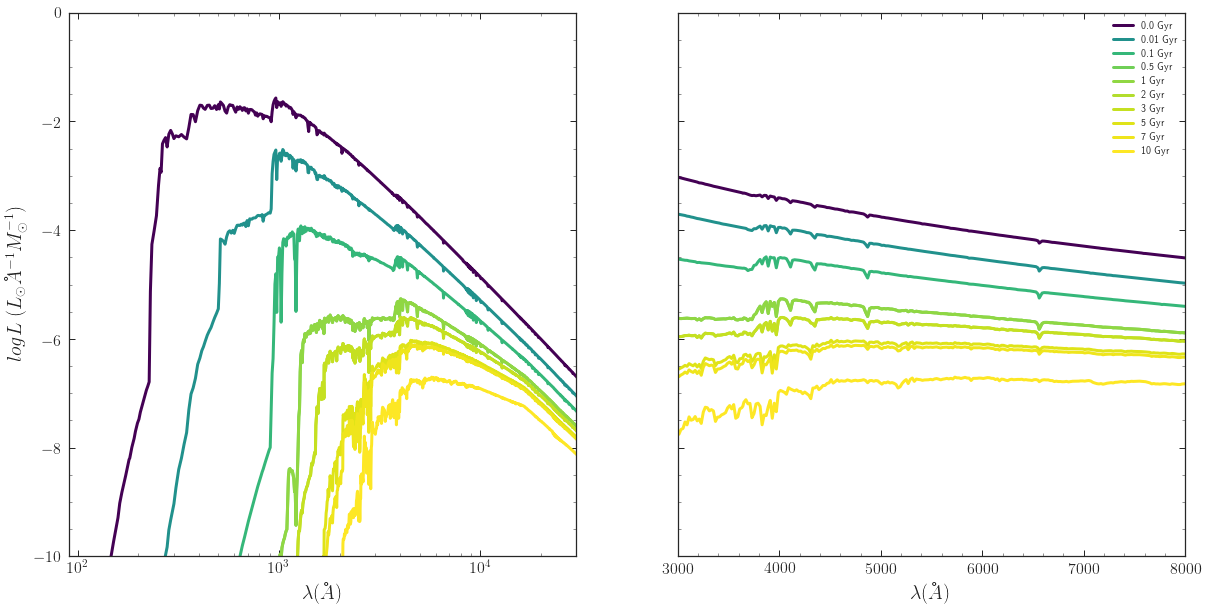

In [54]:
ages = np.array([1e-5, 0.01, 0.1, 0.5, 1, 2, 3, 5, 7, 10])
colorvals = np.log10(ages)
colorvals = colorvals - np.min(colorvals)
colorvals = colorvals / np.max(colorvals)
colors = plt.cm.viridis(colorvals)

# set plotting parameters
plt.rc('text', usetex=True)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

fig, ax = plt.subplots(1, 2, sharey=True, figsize = (20,10))
ax = ax.ravel()
for i in range(len(aged_SED)):
    ax[0].semilogx(wavelengths, np.log10(aged_SED[i]), lw = 3, c = colors[i])
    ax[0].set_xlim(0,3E4)
    ax[0].set_xlabel('$\lambda (\AA)$')
    ax[0].set_ylabel('$log L~ (L_{\odot}\AA^{-1}M_{\odot}^{-1})$')
    ax[1].plot(wavelengths, np.log10(aged_SED[i]), lw = 3, c = colors[i],  label=str(age[i])+' Gyr')
    ax[1].set_xlim(3000, 8000)
    ax[1].set_xlabel('$\lambda (\AA)$')
plt.legend(loc='best')
plt.ylim(-10,0)
plt.savefig('stellar_pop_synthesis.png')

In [60]:
# calculate colors and plot U-B and B-V as a function of time
from ab_flux import abflux

In [63]:
# grab spectra from kurucz models folder and find colors
ub = []; bv = []
for i in range(len(uncorr_SED)):
    flux = uncorr_SED[i] # cgs units
    f = abflux(flux)
    ub.append(f[0]-f[1])
    bv.append(f[1]-f[2])

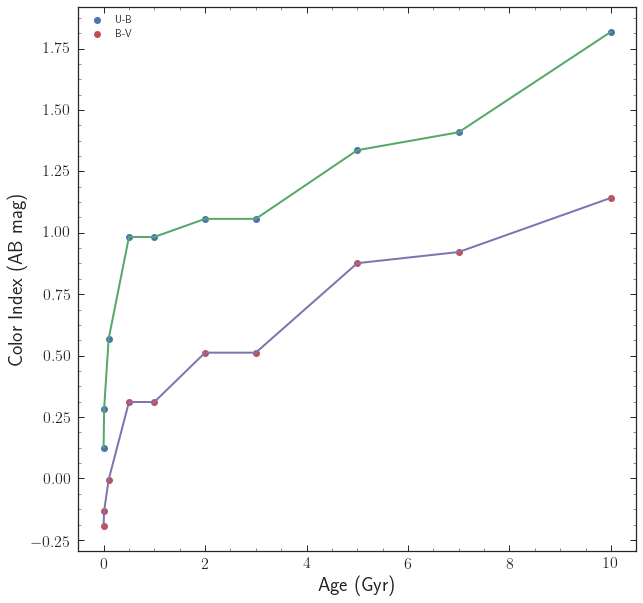

In [69]:
plt.figure(figsize=(10,10))
plt.plot(age, ub, 'o', label='U-B')
plt.plot(age, ub, lw = 2)
plt.plot(age, bv, 'o', label='B-V')
plt.plot(age, bv, lw = 2)
plt.xlabel('Age (Gyr)')
plt.ylabel('Color Index (AB mag)')
plt.legend()
plt.savefig('color_evo.png')

In [70]:
# create latex table from pandas dataframe 
import pandas as pd

In [124]:
Temp = list(np.array(temp)[ms_model])
mlmass = [np.round_(i, decimals =2) for i in mass]
interpmass = [np.round_(i, decimals=2) for i in m]
L = [np.round_(i, decimals = 2) for i in interpL]
logg = list(np.array(log_g)[ms_model])
tau_ms = [np.round_(i, decimals = 4) for i in lifetimes]
r = [np.round_(i, decimals = 4) for i in ratio]
wts = [np.round_(i, decimals = 4) for i in weights]

data = [new_stypes,Temp , mlmass, interpmass, L, logg, tau_ms, r, wts]
columns = ['Spectral Type', 'Temperature (K)', '$Mass~ (M-L)$ ($M_\odot$)', '$Mass~ (Interpolated)$ ($M_\odot$)',\
          'log L ($L_{\odot}$)','log g', '$\tau_{MS}$ (Gyr)', 'Ratio (X/M5V)', 'Weight']

In [128]:
df = pd.DataFrame(data,columns)
df=df.transpose()

In [130]:
with open('table.tex', 'w') as file:
     file.write(df.to_latex(bold_rows = True))